by [scheinmensch](https://github.com/scheinmensch)

In this notebook we will train some simple models without advanced preprocessing or feature engineering in order to get a benchmark accuracy score.

In [1]:
# import packages 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# define RSEED
RSEED = 15

# set color schemes
c = ['#8e9aaf', '#cbc0d3', '#efd3d7', '#dee2ff', '#feeafa']
c2 = ['#ced3dc',
 '#c6ccd7',
 '#c0c7d3',
 '#bdc4d0',
 '#b9c0cd',
 '#b3bbca',
 '#afb7c6',
 '#abb4c4',
 '#a7b1c1',
 '#a3adbe',
 '#a0aabb',
 '#9da8ba',
 '#9aa5b8',
 '#97a2b5',
 '#949fb3',
 '#919db1',
 '#8e9aaf']
cpal2 = ['#F2CC8F', '#81B29A']

# set configurations
from sklearn import set_config
set_config(display='diagram')

In [2]:
# load data
bcn = pd.read_csv('../data/df_modelling.csv')

In [3]:
# first look
bcn.head()

,Unnamed: 0,id,name,description,neighborhood_overview,picture_url,host_id,host_name,host_since,host_location,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,host_type,suspicious_or_not
0,0,13977576,Habitación individual es Barcelona,Mi alojamiento es bueno para aventureros y via...,NaN,https://a0.muscache.com/pictures/7a6e9767-bd4e...,64903899,Carolina,2016-03-29,"Paris, France",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,private,1
1,1,42105584,Habitación M&D,<b>License number</b><br />Exempt,NaN,https://a0.muscache.com/pictures/7342e586-6ea5...,333969184,Midian,2020-02-06,"Barcelona, Spain",...,NaN,NaN,NaN,NaN,NaN,NaN,Exempt,f,private,1
2,2,33727898,Spacious and bright apartment next to Plaza Es...,Hi friends! Welcome to this apartment located ...,The apartment is located in the Eixample quart...,https://a0.muscache.com/pictures/44066458-5997...,251710733,Magda,2019-03-28,NaN,...,4.97,4.97,5.00,5.00,4.83,4.73,HUTB-008684,f,private,1
3,3,44995311,"Single Room, City Center, Private Bathroom",Goya Hostel is a hostel located in the center ...,"The Eixample, which translates as ""widening"" b...",https://a0.muscache.com/pictures/af651bc2-8dff...,363074093,Hostal,2020-08-18,"Barcelona, Spain",...,4.91,4.73,4.91,4.64,4.91,4.73,HUTB-265656,t,commercial,0
4,4,15763812,HABITACIÓN PLAZA ESPAÑA,"Lugares de interés: Poble Espanyol, CaixaForum...",NaN,https://a0.muscache.com/pictures/1bccbbbc-4b78...,101927904,James,2016-10-31,"Barcelona, Spain",...,4.90,4.94,4.96,4.67,4.88,4.60,Exempt,t,private,1


In [4]:
# show how many values are missing per column
missing = pd.DataFrame(bcn.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/bcn.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage
name,6,0.05
description,55,0.49
neighborhood_overview,4480,39.51
host_name,2,0.02
host_since,2,0.02
host_location,2502,22.06
host_about,4075,35.93
host_response_time,2048,18.06
host_response_rate,2048,18.06
host_acceptance_rate,1685,14.86


In [5]:
#drop columns with all NaN values
df_bl = bcn.drop(['bathrooms', 'calendar_updated'], axis=1)

In [6]:
#drop some columns which we won't use
df_bl.drop(['Unnamed: 0', 'id', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_id', 'host_name', 'host_location',
       'host_about', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'bathrooms_text', 'beds', 'amenities', 'host_total_listings_count', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'host_verifications' ], axis=1, inplace=True)

In [7]:
#check if those with NaN in many host related columns are always the same two
host_nans = df_bl[df_bl['host_since'].isna()]
host_nans

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,room_type,...,bedrooms,price,minimum_nights,maximum_nights,has_availability,number_of_reviews,license,instant_bookable,host_type,suspicious_or_not
3465,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,Eixample,Private room,...,1.0,$50.00,2,1125,t,1,NaN,f,private,1
11104,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,Les Corts,Private room,...,1.0,$50.00,1,1125,t,0,NaN,f,private,1


In [8]:
# since they are, we delete them
df_bl=df_bl.dropna(subset=['host_since'])

## change some dtypes

In [9]:
# hoste_since to datetime
df_bl['host_since']= pd.to_datetime(df_bl['host_since'])

In [10]:
# price to float
df_bl['price'] = df_bl['price'].str[1:]
df_bl['price'] = df_bl['price'].str.replace(',','')
df_bl['price'] = pd.to_numeric(df_bl['price'])

In [11]:
# host_response_rate and host_acceptance_rate to float
df_bl['host_response_rate'] = df_bl['host_response_rate'].str.rstrip("%").astype(float)/100
df_bl['host_acceptance_rate'] = df_bl['host_acceptance_rate'].str.rstrip("%").astype(float)/100

In [12]:
# some boolean to 0/1
le = LabelEncoder()
df_bl['host_is_superhost'] = le.fit_transform(df_bl['host_is_superhost'])
df_bl['host_has_profile_pic'] = le.fit_transform(df_bl['host_has_profile_pic'])
df_bl['host_identity_verified'] = le.fit_transform(df_bl['host_identity_verified'])
df_bl['has_availability'] = le.fit_transform(df_bl['has_availability'])
df_bl['instant_bookable'] = le.fit_transform(df_bl['instant_bookable'])

In [13]:
# host_listings_count as int
df_bl['host_listings_count'] = df_bl['host_listings_count'].astype(int)

## train test split

In [14]:
# separate features and target variable
X = df_bl.drop('suspicious_or_not', axis=1)
y = df_bl['suspicious_or_not']

In [15]:
# perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

In [16]:
# show sizes of dataframes
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (9070, 20)
X_test shape: (2268, 20)
y_train shape: (9070,)
y_test shape: (2268,)


In [17]:
# get info on trainings data
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9070 entries, 9627 to 7625
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   host_since                    9070 non-null   datetime64[ns]
 1   host_response_time            7420 non-null   object        
 2   host_response_rate            7420 non-null   float64       
 3   host_acceptance_rate          7719 non-null   float64       
 4   host_is_superhost             9070 non-null   int64         
 5   host_listings_count           9070 non-null   int64         
 6   host_has_profile_pic          9070 non-null   int64         
 7   host_identity_verified        9070 non-null   int64         
 8   neighbourhood_group_cleansed  9070 non-null   object        
 9   room_type                     9070 non-null   object        
 10  accommodates                  9070 non-null   int64         
 11  bedrooms                      87

## Preprocessing

### handling numerical

In [18]:
# define mode of train data for imputation
hrt_mode = X_train['host_response_time'].mode()
# define mean of train data for imputation
hrr_mean = X_train['host_response_rate'].mean()
# define mean of train data for imputation
har_mean = X_train['host_acceptance_rate'].mean()
# define mode of train data for imputation
br_mode = X_train['bedrooms'].mode()

In [19]:
# apply both on train and test data
X_train = X_train.fillna(value = {'host_response_time':'within an hour', 'host_response_rate': 0.94,'host_acceptance_rate': 0.89,'bedrooms':1.0})
X_test = X_test.fillna(value = {'host_response_time':'within an hour', 'host_response_rate': 0.94,'host_acceptance_rate': 0.89,'bedrooms':1.0})

In [20]:
# handle licenses
# write function
def license(license):
    if 'HUTB' in license:
        return 1
    if 'HB' in license:
        return 1
    if 'AJ' in license:
        return 1
    elif 'exempt' in license.lower():
        return 0
    else:
        return 0

In [21]:
# fill missing licenses with "no"
X_train['license'] = X_train['license'].fillna('no')
X_test['license'] = X_test['license'].fillna('no')

In [22]:
# apply license function on train and test data
X_train['license'] = X_train.apply(lambda row: license(row['license']), axis=1)
X_test['license'] = X_test.apply(lambda row: license(row['license']), axis=1)

### handling categorical
*(this is the first time that I try out pipelines, I keep it simple here)*

In [23]:
# define a list of categorical features
cat_features = list(X_train.columns[X_train.dtypes==object])

In [24]:
# show them
cat_features

['host_response_time',
 'neighbourhood_group_cleansed',
 'room_type',
 'host_type']

In [25]:
# define a pipeline for categorical features (all categorical features will be onehotencoded)
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [26]:
# define a preprocessor that applies the pipeline on the categorical features
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features)
])

## Baseline Model Log Reg

In [27]:
# define a pipeline for the logistic regression 
pipe_logreg_bl = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [28]:
# get scores how logistic regression performs on trainings data
y_train_predicted_bl = cross_val_predict(pipe_logreg_bl, X_train, y_train, cv=5)

In [29]:
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_bl)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_bl)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_bl)))

Cross validation scores:
-------------------------
Accuracy: 0.78
Recall: 0.80
Precision: 0.74


In [30]:
# try a hyperparameter optimization with gridsearchcv

# define parameters to test
param_logreg_bl = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                'logreg__solver': ['liblinear', 'lbfgs', 'sag'],
               }

# define grid search
grid_logreg_bl = GridSearchCV(pipe_logreg_bl, param_grid=param_logreg_bl, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

In [31]:
# run grid search
grid_logreg_bl.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/johannakruger/neuefische/Modellbauer/.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['host_response_time',
                                                                          'neighbourhood_group_cleansed',
                                                                          'room_type',
                                                                          'host_type'])])),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                         'logreg__penalty': ('l1', 'l2'),
                         'logreg__solver': ['liblinear', 'lbfgs', 'sag']},
             scoring='accuracy', verbose=5)

In [32]:
# print best score and best parameters
print('Best score:\n{:.2f}'.format(grid_logreg_bl.best_score_))
print("Best parameters:\n{}".format(grid_logreg_bl.best_params_))

Best score:
0.78
Best parameters:
{'logreg__C': 0.01, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [33]:
# save model with best parameters in a variable
baselinemodel = grid_logreg_bl.best_estimator_
baselinemodel

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'neighbourhood_group_cleansed',
                                                   'room_type',
                                                   'host_type'])])),
                ('logreg',
                 LogisticRegression(C=0.01, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [34]:
# apply model on test data
y_test_predicted_bl = baselinemodel.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_bl)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_bl)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_bl)))

Accuracy: 0.79
Recall: 0.82
Precision: 0.74


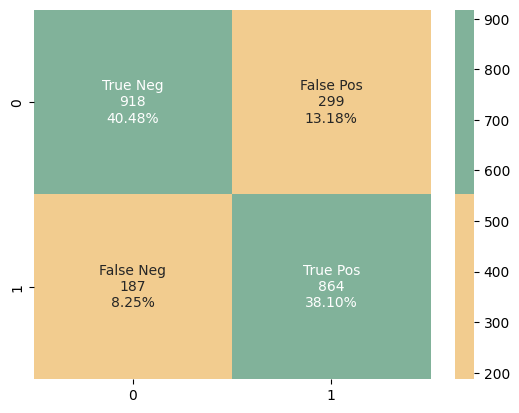

In [35]:
cfm_bl = confusion_matrix(y_test, y_test_predicted_bl)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_bl.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_bl.flatten()/np.sum(cfm_bl)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_bl, annot=labels, fmt='', cmap=cpal2);

In [36]:
# get probabilities
y_test_proba_bl = baselinemodel.predict_proba(X_test)

In [37]:
y_test_proba_bl = y_test_proba_bl[:,1]

In [38]:
# AUC Score 
bl_auc = roc_auc_score(y_test, y_test_proba_bl)
bl_auc

0.8371250294159727

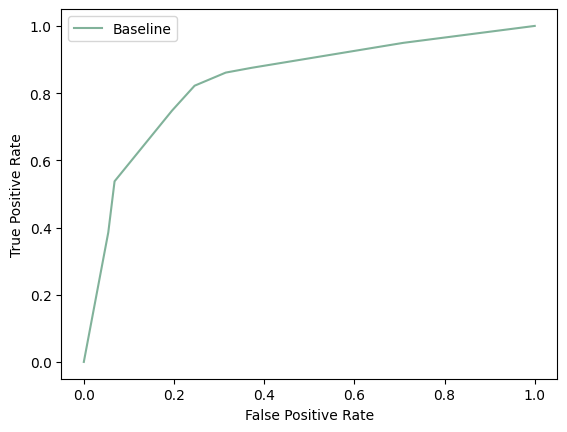

In [39]:
# plot ROC-AUC-Curve 
fprbl, tprbl, thresholdsbl = roc_curve(y_test, y_test_proba_bl)

from matplotlib import pyplot
pyplot.plot(fprbl, tprbl, label='Baseline', color='#81B29A')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

Our Baselinemodel (Logistic Regression) shows already good results. But we know we can improve this a lot!

# Modelling

We will repeat that for a random forest, just in comparision.

## Random Forest

In [40]:
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('randfor', RandomForestClassifier(random_state=RSEED))
])

y_train_predicted_rf = cross_val_predict(pipe_rf, X_train, y_train, cv=5)

print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_rf)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_rf)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_rf)))

Cross validation scores:
-------------------------
Accuracy: 0.78
Recall: 0.72
Precision: 0.79


In [41]:
param_rf_all = {'randfor__n_estimators':[100, 500, 1000, 1500, 2000],
                'randfor__min_samples_split': [2, 5, 10, 15, 20],
                'randfor__max_depth': [10,20,50,80,100],
                'randfor__max_features': ['auto', 'sqrt'],
                'randfor__min_samples_leaf' : [1,2,4],
                'randfor__bootstrap': [True, False],
              }

Best parameters
{'randfor__bootstrap': True, 'randfor__max_depth': 80, 'randfor__max_features': 'auto', 'randfor__min_samples_leaf': 2, 'randfor__min_samples_split': 5, 'randfor__n_estimators': 100}

In [42]:
param_rf_best = {'randfor__n_estimators':[100],
                'randfor__min_samples_split': [5],
                'randfor__max_depth': [80],
                'randfor__max_features': ['auto'],
                'randfor__min_samples_leaf' : [2],
                'randfor__bootstrap': [True],
             }

In [43]:
grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf_best, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)

grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/johannakruger/neuefische/Modellbauer/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['host_response_time',
                                                                          'neighbourhood_group_cleansed',
                                                                          'room_type',
                                                                          'host_type'])])),
                                       ('randfor',
                                        RandomForestClassifier(random_state=15))]),
             n_jobs=-1,
             param_grid={'randfor__bootstrap': [True],
                         'randfor__max_depth': [80],
                         'randfor__max_features': ['auto'],
                         'randfor__min_samples_leaf': [2],
                         'randfor__min_samples_split': [5],
                         'randfor__n_estimators': [100]},
             scoring='precision', verbose=5)

In [44]:
print('Best score:\n{:.2f}'.format(grid_rf.best_score_))
print("Best parameters:\n{}".format(grid_rf.best_params_))

Best score:
0.78
Best parameters:
{'randfor__bootstrap': True, 'randfor__max_depth': 80, 'randfor__max_features': 'auto', 'randfor__min_samples_leaf': 2, 'randfor__min_samples_split': 5, 'randfor__n_estimators': 100}


In [45]:
randomforest = grid_rf.best_estimator_
randomforest

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'neighbourhood_group_cleansed',
                                                   'room_type',
                                                   'host_type'])])),
                ('randfor',
                 RandomForestClassifier(max_depth=80, max_features='auto',
                                        min_samples_leaf=2, min_samples_split=5,
                                        random_state=15))])

In [46]:
y_test_predicted_rf = randomforest.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_rf)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_rf)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_rf)))

Accuracy: 0.79
Recall: 0.72
Precision: 0.81


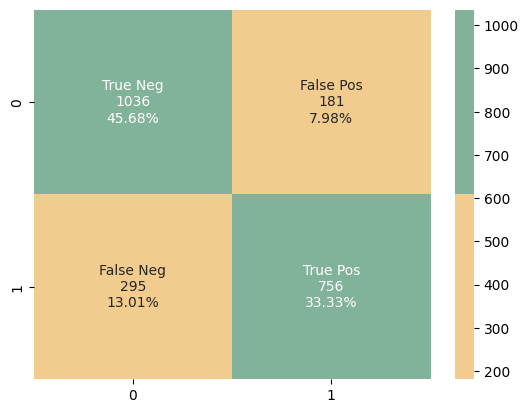

In [47]:
cfm_rf = confusion_matrix(y_test, y_test_predicted_rf)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_rf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_rf.flatten()/np.sum(cfm_bl)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_rf, annot=labels, fmt='', cmap=cpal2);

In [48]:
y_test_proba_rf = randomforest.predict_proba(X_test)
y_test_proba_rf = y_test_proba_rf[:,1]
rf_auc = roc_auc_score(y_test, y_test_proba_rf)
fprrf, tprrf, thresholdsrf = roc_curve(y_test, y_test_proba_rf)

In [49]:
rf_auc

0.8554590963569538

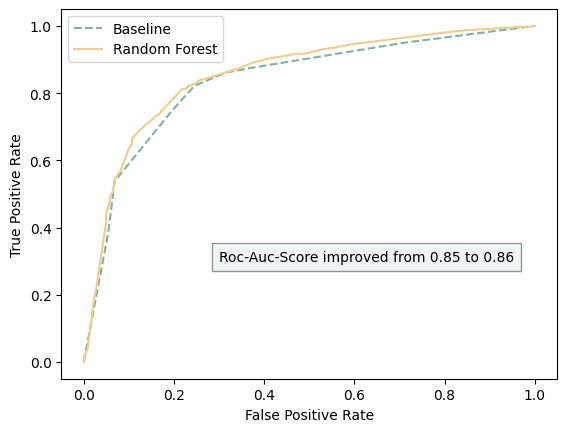

In [50]:
from matplotlib import pyplot
pyplot.plot(fprbl, tprbl, linestyle='--', label='Baseline', color='#81B29A')
pyplot.plot(fprrf, tprrf, label='Random Forest', color = '#F2CC8F')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.text(0.3,0.3,'Roc-Auc-Score improved from 0.85 to 0.86', bbox={
        'facecolor': '#D9E8E8', 'alpha': 0.4, 'pad': 5})
pyplot.legend()
pyplot.show()

In the next notebook we are going to improve this and train our final model.